In [ ]:
import numpy as np
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras.models import Model, load_model
from keras.preprocessing.image import ImageDataGenerator, img_to_array, array_to_img, load_img
import matplotlib.pyplot as plt
from keras.utils import layer_utils
from keras.applications.imagenet_utils import preprocess_input
from keras.utils import to_categorical
from keras.initializers import glorot_uniform
import os
from imutils import paths
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils
import cv2
%matplotlib inline
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import keras.backend as K
K.set_image_data_format('channels_last')
K.set_learning_phase(1)

In [ ]:
#Identity Block
def identity_block(X, f, filters, stage, block):
  F1, F2, F3 = filters
  X_replica = X

  conv_name = 'res' + str(stage) + block + '_branch'
  bnorm_name = 'bnorm' + str(stage) + block + '_branch'

  #1st main path
  X = Conv2D(F1, (1,1), strides= (1,1), padding= 'valid', name = conv_name + '2a', kernel_initializer= glorot_uniform(seed=0))(X)
  X = BatchNormalization(axis= 3, name = bnorm_name + '2a')(X)
  X = Activation('relu')(X)

  #2nd main path
  X = Conv2D(F2, (f,f), strides= (1,1), padding= 'same', name = conv_name + '2b', kernel_initializer= glorot_uniform(seed=0))(X)
  X = BatchNormalization(axis= 3, name = bnorm_name + '2b')(X)
  X = Activation('relu')(X)

  #3rd main path
  X = Conv2D(F3, (1,1), strides= (1,1), padding= 'valid', name = conv_name + '2c', kernel_initializer= glorot_uniform(seed=0))(X)
  X = BatchNormalization(axis= 3, name = bnorm_name + '2c')(X)

  #skip connection
  X = Add()([X, X_replica])
  X = Activation('relu')(X)

  return X

In [ ]:
#convolutional_block
def convolutional_block(X, f, filters, stage, block, s = 2):
  F1, F2, F3 = filters
  X_replica = X

  conv_name = 'res' + str(stage) + block + '_branch'
  bnorm_name = 'bnorm' + str(stage) + block + '_branch'

  #Main path
  #1st layer
  X = Conv2D(F1, (1,1), strides= (s,s), name = conv_name + '2a', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis = 3, name= bnorm_name + '2a')(X)
  X = Activation('relu')(X)

  #2nd layer
  X = Conv2D(F2, (f,f), strides= (1,1), name = conv_name + '2b', padding= 'same', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis = 3, name= bnorm_name + '2b')(X)
  X = Activation('relu')(X)

  #3rd layer
  X = Conv2D(F3, (1,1), strides= (1,1), name = conv_name + '2c', padding= 'valid', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis = 3, name= bnorm_name + '2c')(X)

  #skip connections
  X_replica = Conv2D(F3, (1,1), strides= (s,s), name = conv_name + '1', padding='valid', kernel_initializer= glorot_uniform(seed = 0))(X_replica)
  X_replica = BatchNormalization(axis = 3, name = bnorm_name + '1')(X_replica)

  #relu
  X = Add()([X, X_replica])
  X = Activation('relu')(X)

  return X

In [ ]:
#ResNet model
def ResNet50(input_shape= (64,64,3), classes= 17):
  X_input = Input(input_shape)
  X = ZeroPadding2D(padding= (3,3))(X_input)

  #stage 1
  X = Conv2D(64, (7,7), strides= (2,2), name= 'conv1', kernel_initializer=glorot_uniform(seed=0))(X)
  X = BatchNormalization(axis = 3, name= 'bn_conv1')(X)
  X = Activation('relu')(X)
  X = MaxPooling2D((3,3), strides= (2,2))(X)

  #stage 2
  X = convolutional_block(X, f=3, filters= [64,64,256], stage=2, block= 'a', s=1)
  X = identity_block(X, f=3, filters= [64,64,256], stage=2, block='b')
  X = identity_block(X, f=3, filters= [64,64,256], stage=2, block='c')

  #stage 3
  X = convolutional_block(X, f=3, filters= [128,128,512], stage=3, block= 'a', s=2)
  X = identity_block(X, f=3, filters= [128,128,512], stage=3, block='b')
  X = identity_block(X, f=3, filters= [128,128,512], stage=3, block='c')
  X = identity_block(X, f=3, filters= [128,128,512], stage=3, block='d')

  #stage 4
  X = convolutional_block(X, f = 3, filters = [256, 256, 1024], stage=4, block='a', s = 2)
  X = identity_block(X, f= 3, filters= [256, 256, 1024], stage=4, block='b')
  X = identity_block(X, f= 3, filters= [256, 256, 1024], stage=4, block='c')
  X = identity_block(X, f= 3, filters= [256, 256, 1024], stage=4, block='d')
  X = identity_block(X, f= 3, filters= [256, 256, 1024], stage=4, block='e')
  X = identity_block(X, f= 3, filters= [256, 256, 1024], stage=4, block='f')

  #stage 5
  X = convolutional_block(X, f = 3, filters = [512, 512, 2048], stage=5, block='a', s = 2)
  X = identity_block(X, f= 3, filters= [512, 512, 2048], stage=5, block='b')
  X = identity_block(X, f= 3, filters= [512, 512, 2048], stage=5, block='c')

  X = AveragePooling2D()(X)

  X = Flatten()(X)
  X = Dense(classes, activation= 'softmax', name='fc' + str(classes), kernel_initializer= glorot_uniform(seed= 0))(X)

  model = Model(inputs = X_input, outputs = X, name='ResNet50')
  return model

In [ ]:
model = ResNet50(input_shape = (64, 64, 3), classes = 17)

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "ResNet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 70, 70, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 32, 32, 64)   9472        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 32, 32, 64)   256         conv1[0][0]                      
___________________________________________________________________________________________

In [ ]:
imagePaths = list(paths.list_images('/content/drive/My Drive/Flowers_CNN/dataset/Flowers'))
data = []
labels = []
print(imagePaths)

['/content/drive/My Drive/Flowers_CNN/dataset/Flowers/Dandelion/image_0966.jpg', '/content/drive/My Drive/Flowers_CNN/dataset/Flowers/Dandelion/image_0967.jpg', '/content/drive/My Drive/Flowers_CNN/dataset/Flowers/Dandelion/image_0964.jpg', '/content/drive/My Drive/Flowers_CNN/dataset/Flowers/Dandelion/image_0968.jpg', '/content/drive/My Drive/Flowers_CNN/dataset/Flowers/Dandelion/image_0965.jpg', '/content/drive/My Drive/Flowers_CNN/dataset/Flowers/Dandelion/image_0973.jpg', '/content/drive/My Drive/Flowers_CNN/dataset/Flowers/Dandelion/image_0969.jpg', '/content/drive/My Drive/Flowers_CNN/dataset/Flowers/Dandelion/image_0970.jpg', '/content/drive/My Drive/Flowers_CNN/dataset/Flowers/Dandelion/image_0971.jpg', '/content/drive/My Drive/Flowers_CNN/dataset/Flowers/Dandelion/image_0972.jpg', '/content/drive/My Drive/Flowers_CNN/dataset/Flowers/Dandelion/image_0975.jpg', '/content/drive/My Drive/Flowers_CNN/dataset/Flowers/Dandelion/image_0976.jpg', '/content/drive/My Drive/Flowers_CNN/da

In [ ]:
imageSize = (64, 64)
for imagePath in imagePaths:
  label = imagePath.split(os.path.sep)[-2]
  image = cv2.imread(imagePath)
  image = cv2.resize(image, imageSize)
  labels.append(label)
  data.append(image)

In [ ]:
print(len(data), len(labels))

1360 1360


In [ ]:
data = np.array(data, dtype="float") / 255.0

In [ ]:
lbl = LabelEncoder()
targets = lbl.fit_transform(labels)
targets = to_categorical(targets, 17)

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(data, targets, test_size=0.2, random_state=42)

In [ ]:
print ("number of training examples = " + str(x_train.shape[0]))
print ("number of test examples = " + str(x_test.shape[0]))
print ("x_train shape: " + str(x_train.shape))
print ("y_train shape: " + str(y_train.shape))
print ("x_test shape: " + str(x_test.shape))
print ("y_test shape: " + str(y_test.shape))

number of training examples = 1088
number of test examples = 272
x_train shape: (1088, 64, 64, 3)
y_train shape: (1088, 17)
x_test shape: (272, 64, 64, 3)
y_test shape: (272, 17)


In [ ]:
model.fit(x_train, y_train, epochs = 25, batch_size = 32, verbose= 1)

Epoch 1/25
1088/1088 [==============================] - 218s 200ms/step - loss: 4.3106 - accuracy: 0.1002
Epoch 2/25
1088/1088 [==============================] - 211s 194ms/step - loss: 3.3014 - accuracy: 0.2169
Epoch 3/25
1088/1088 [==============================] - 213s 196ms/step - loss: 2.6459 - accuracy: 0.2914
Epoch 4/25
1088/1088 [==============================] - 195s 179ms/step - loss: 2.0088 - accuracy: 0.4007
Epoch 5/25
1088/1088 [==============================] - 176s 162ms/step - loss: 2.1777 - accuracy: 0.4439
Epoch 6/25
1088/1088 [==============================] - 190s 175ms/step - loss: 1.6527 - accuracy: 0.5294
Epoch 7/25
1088/1088 [==============================] - 184s 169ms/step - loss: 1.6003 - accuracy: 0.5855
Epoch 8/25
1088/1088 [==============================] - 204s 188ms/step - loss: 1.3451 - accuracy: 0.6664
Epoch 9/25
1088/1088 [==============================] - 203s 187ms/step - loss: 1.0121 - accuracy: 0.7169
Epoch 10/25
1088/1088 [=======================

In [ ]:
preds = model.evaluate(x_test, y_test)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

In [ ]:
test_image = load_img('/content/p16.jpg', target_size = (64, 64))
test_image = img_to_array(test_image)
test_image = np.expand_dims(test_image, axis=0)
test_image = test_image/255.0
print(model.predict(test_image))

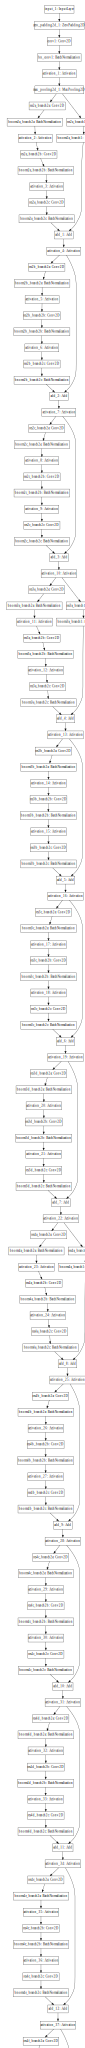

In [ ]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
plot_model(model, to_file='model.png')
SVG(model_to_dot(model).create(prog='dot', format='svg'))